2024-01-31


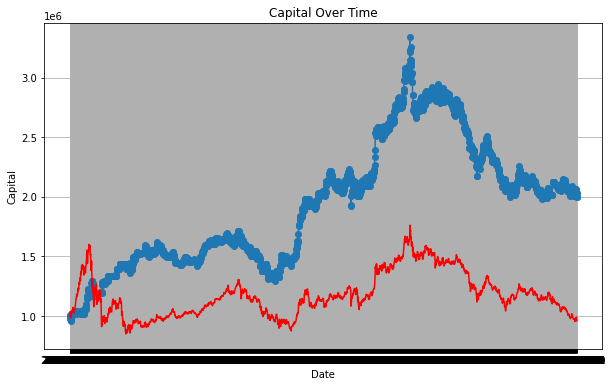

In [35]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors

stock_hsgt_hist_em_df = ak.stock_hsgt_hist_em(symbol="北向资金")

# [start_date, end_date)
def get_group_thresholds(start_date, end_date):
    # 将日期列转换为datetime类型
    stock_hsgt_hist_em_df['日期'] = pd.to_datetime(stock_hsgt_hist_em_df['日期'])
    
    # 筛选指定日期范围内的数据
    filtered_df = stock_hsgt_hist_em_df[(stock_hsgt_hist_em_df['日期'] >= start_date) & (stock_hsgt_hist_em_df['日期'] < end_date)]
    
    if not filtered_df.empty:
        last_inflow = filtered_df.iloc[-1]['当日资金流入']
    else:
        last_inflow = None
        
    # 提取“当日成交净买额”列，并按降序排序
    net_buy_amounts = filtered_df['当日资金流入'].sort_values(ascending=False)
    
    # 计算每组的大小
    total_count = len(net_buy_amounts)
    group_size = total_count // 3
    remainder = total_count % 3
    
    # 确定每组的边界索引
    group_boundaries = [group_size, group_size * 2, total_count]
    
    # 如果不能均分，调整最后一组的大小
    if remainder == 1:
        group_boundaries[1] += 1
    elif remainder == 2:
        group_boundaries[0] += 1
        group_boundaries[1] += 1
    
    # 获取每组的临界值
    group1_threshold = net_buy_amounts.iloc[group_boundaries[0] - 1] if total_count > 0 else None
    group2_threshold = net_buy_amounts.iloc[group_boundaries[1] - 1] if total_count > 0 else None
    
    return group1_threshold, group2_threshold, last_inflow


hs300hd = pd.read_csv("./hs300_k.csv")
hs300hd = hs300hd[(hs300hd['date'] >= "2015-02-01") & (hs300hd['date'] < "2024-02-01")]

# 初始资金
initial_capital = 1000000
# 当前股票份额
stock_num = 0
# 当前资金
current_capital = initial_capital
# 记录每次卖出的时间和资金数
sell_records = []

hs300_capital = 1000000
hs300_stock_num = 0
hs300_records = []

# 遍历每一行，计算收益
for index, row in hs300hd.iterrows():
    line1, line2, last_in = get_group_thresholds("2014-11-17", row['date'])
    
    hs300_stock_num += hs300_capital / row['open']
    hs300_capital = 0
    hs300_records.append((row['date'], hs300_capital+hs300_stock_num * row['open']))
    
    action = ""
    if last_in > line1:
        # 买入股票
        action = "buy"
        # 扣除手续费
        current_capital = current_capital*0.99975
        stock_num += current_capital / row['open']
        current_capital = 0
    elif last_in < line2 and stock_num > 0:
        action = "sold"
        # 卖出股票
        current_capital += stock_num * row['open']
        # 手续费
        current_capital = current_capital*0.99975
        stock_num = 0
    sell_records.append((row['date'], current_capital+stock_num * row['open']))
    # print(row['date'], (line1, line2, last_in), action, sell_records[-1])

# 最后一行全部卖出
if stock_num > 0:
    current_capital += stock_num * hs300hd.iloc[-1]['open']
    sell_records.append((hs300hd.iloc[-1]['date'], current_capital))
    
    hs300_records.append((hs300hd.iloc[-1]['date'], hs300_stock_num*hs300hd.iloc[-1]['open']))
    
    

print(sell_records[-1][0])
    
# 将卖出记录转换为 DataFrame
sell_df = pd.DataFrame(sell_records, columns=['date', 'capital'])
hs300_df = pd.DataFrame(hs300_records, columns=['date', 'capital'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sell_df['date'], sell_df['capital'], marker='o')# 绘制开盘价折线
ax.plot(hs300_df['date'], hs300_df['capital'], label='Open Price', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Capital')
ax.set_title('Capital Over Time')
ax.grid(True)

# 添加交互功能
mplcursors.cursor(hover=True)

plt.show()
